### Chapter 3 : Linear Neural Network
Main content:
- Minibatch stochastic gradient descent (小批量随机梯度下降)
- 一般的训练过程
  - model.forward() 与 y_hat 做差，然后反向传播，优化器根据导数去更新参数
- Machine Learning Concept
  - lasso regression: l1 norm; ridge regression: l2 norm;

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

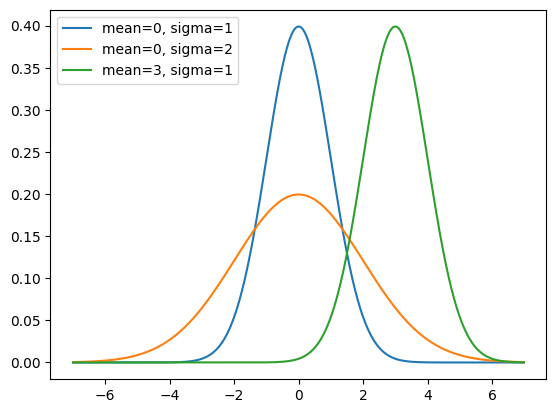

In [2]:
%matplotlib inline
import math
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

x = np.arange(-7, 7, 0.01)
params = [(0, 1), (0, 2), (3, 1)]
data = [normal(x, mu, sigma) for mu, sigma in params]
for i in range(3):
    plt.plot(x, data[i], label=f"mean={params[i][0]}, sigma={params[i][1]}")
plt.legend()

torch.Size([1000, 2]) torch.Size([1000, 1])


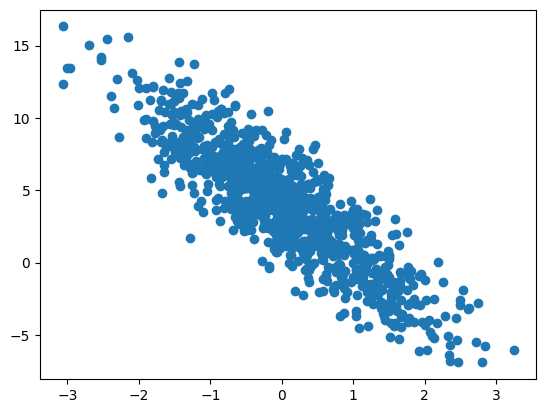

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.shape, labels.shape)
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy())

In [4]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [5]:
# 不调用API的复杂实现
batch_size = 10

# w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
w = torch.zeros(size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

class model():
    def __init__(self, w, b):
        self.w = w
        self.b = b
    def forward(self, X):
        return torch.matmul(X, self.w) + self.b
    
def loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params : torch.Tensor, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

my_model = model(w, b)
num_epochs = 10
lr = 0.03
print(true_w, true_b)
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(my_model.forward(X), y)
        l.sum().backward()
        sgd([my_model.w, my_model.b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(my_model.forward(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
print(my_model.w, my_model.b)   


tensor([ 2.0000, -3.4000]) 4.2
epoch 1, loss 0.046667
epoch 2, loss 0.000191
epoch 3, loss 0.000049
epoch 4, loss 0.000048
epoch 5, loss 0.000048
epoch 6, loss 0.000048
epoch 7, loss 0.000048
epoch 8, loss 0.000048
epoch 9, loss 0.000048
epoch 10, loss 0.000048
tensor([[ 1.9998],
        [-3.4000]], requires_grad=True) tensor([4.1993], requires_grad=True)


epoch 1, loss 3.861957
epoch 2, loss 3.372871
epoch 3, loss 3.544516


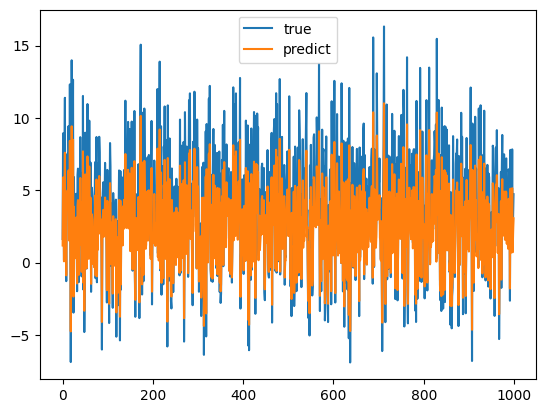

In [24]:
# 调用API的简单实现
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 8
data_iter = load_array((features, labels), batch_size)

from torch import nn
model_with_api = nn.Sequential(nn.Linear(2, 1))
model_with_api[0].weight.data.normal_(0, 0.01)
model_with_api[0].bias.data.fill_(0)

loss = nn.MSELoss()
#　trainer = torch.optim.SGD(model_with_api.parameters(), lr=0.03)
trainer = torch.optim.SGD(model_with_api.parameters(), weight_decay=1, lr = 0.03)
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(model_with_api(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(model_with_api(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

plt.plot(labels, label="true")
plt.plot(model_with_api(features).detach().numpy(), label="predict")
plt.legend()